<a href="https://colab.research.google.com/github/faithNassiwa/predictive-diagnosis-assistant/blob/main/models/Dataset2_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint

In [ ]:
# Mount google drive to access folder with data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the training and test dataset -- Took a minute
train_df = pd.read_csv('/content/drive/MyDrive/DS5500/Data/Dataset2/processed_train.csv', low_memory=False)
test_df = pd.read_csv('/content/drive/MyDrive/DS5500/Data/Dataset2/processed_test.csv', low_memory=False)
pprint(f'Train dataset shape: {train_df.shape}')
pprint(f'Test dataset shape: {test_df.shape}')


'Train dataset shape: (1025602, 221)'
'Test dataset shape: (134529, 221)'


In [ ]:
# Prepare training and test variables
X_columns = [col for col in train_df.columns if col not in ['Unnamed: 0', 'PATHOLOGY']]
X_train = train_df[X_columns]
y_train = train_df['PATHOLOGY']
X_test = test_df[X_columns]
y_test = test_df['PATHOLOGY']
pprint(f'X_train shape: {X_train.shape}')
pprint(f'y_train shape: {y_train.shape}')
pprint(f'X_test shape: {X_test.shape}')
pprint(f'y_test shape: {y_test.shape}')


'X_train shape: (1025602, 219)'
'y_train shape: (1025602,)'
'X_test shape: (134529, 219)'
'y_test shape: (134529,)'


In [ ]:
# Info about data and categorical columns
X_train.info()
categorical_column_data_types = {col: X_train[col].dtype for col in X_train.columns if X_train[col].dtype == 'O'}
pprint(categorical_column_data_types)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025602 entries, 0 to 1025601
Columns: 219 entries, AGE to Are you of Asian descent?
dtypes: float64(208), int64(1), object(10)
memory usage: 1.7+ GB
{'Characterize your pain:': dtype('O'),
 'Do you feel pain somewhere?': dtype('O'),
 'Do your lesions peel off?': dtype('O'),
 'Does the pain radiate to another location?': dtype('O'),
 'Have you traveled out of the country in the last 4 weeks?': dtype('O'),
 'Is the lesion (or are the lesions) larger than 1cm?': dtype('O'),
 'SEX': dtype('O'),
 'What color is the rash?': dtype('O'),
 'Where is the affected region located?': dtype('O'),
 'Where is the swelling located?': dtype('O')}


In [ ]:
# View values of categorical columns
unique_values = {col: X_train[col].unique() for col in X_train.columns if X_train[col].dtype == 'O'}
pprint(unique_values)


{'Characterize your pain:': array(['heavy', 'exhausting', 'sharp', 'burning', 'a cramp', '0',
       'heartbreaking', 'sickening', 'sensitive', 'scary',
       'a knife stroke', 'tugging', 'violent', 'a pulse', 'haunting',
       'tedious', nan], dtype=object),
 'Do you feel pain somewhere?': array(['temple(L)', 'posterior chest wall(L)', 'eye(R)', 'pharynx', '0',
       'temple(R)', 'epigastric', 'breast(L)', 'iliac fossa(L)', 'pubis',
       'occiput', 'testicle(L)', 'posterior chest wall(R)', 'shoulder(L)',
       'under the jaw', 'hypochondrium(R)', 'forehead', 'trachea',
       'sole(L)', 'finger (middle)(R)', 'shoulder(R)', 'breast(R)',
       'dorsal aspect of the foot(L)', 'belly', 'eye(L)', 'nose',
       'hip(L)', 'top of the head', 'triceps(R)', 'finger (middle)(L)',
       'ear(L)', 'ear(R)', 'nowhere', 'sole(R)', 'upper chest',
       'cheek(L)', 'hypochondrium(L)', 'knee(R)', 'back of head',
       'palace', 'testicle(R)', 'lower chest',
       'dorsal aspect of the foot(

In [ ]:
# Check if there are any nans columns
pprint(train_df.columns[train_df.isna().any()].tolist())
pprint(test_df.columns[test_df.isna().any()].tolist())

['Characterize your pain:', 'What color is the rash?']
['Characterize your pain:', 'What color is the rash?']


In [ ]:
# Count of NAN in the columns -- drop these
print(train_df['Characterize your pain:'].isna().sum())
print(train_df['What color is the rash?'].isna().sum())
print(test_df['Characterize your pain:'].isna().sum())
print(test_df['What color is the rash?'].isna().sum())

10859
32609
1379
4436


In [ ]:
# Fill nans with zeros as used in respective columns
pd.options.mode.chained_assignment = None
X_train.loc[:, 'Characterize your pain:'] = X_train['Characterize your pain:'].fillna(0)
X_train.loc[:, 'What color is the rash?'] = X_train['What color is the rash?'].fillna(0)
X_test.loc[:, 'Characterize your pain:'] = X_test['Characterize your pain:'].fillna(0)
X_test.loc[:, 'What color is the rash?'] = X_test['What color is the rash?'].fillna(0)

In [ ]:
# Count of NAN in the columns
print(X_train['Characterize your pain:'].isna().sum())
print(X_train['What color is the rash?'].isna().sum())
print(X_test['Characterize your pain:'].isna().sum())
print(X_test['What color is the rash?'].isna().sum())

0
0
0
0


In [ ]:
# One-Hot encode all categorical values to create new columns for categorical values - alter to label

categorical_columns = list(unique_values.keys())

# Reset indices of both X_train and X_test
X_train_reset = X_train.reset_index(drop=True)
X_test_reset = X_test.reset_index(drop=True)

# Combine the train and test data
combined = pd.concat([X_train_reset, X_test_reset], axis=0)

# One-hot encode the combined dataframe
combined_encoded = pd.get_dummies(combined, columns=categorical_columns)

# Split the combined_encoded dataframe back into train and test
X_train_encoded = combined_encoded.iloc[:len(X_train)]
X_test_encoded = combined_encoded.iloc[len(X_train):]

In [ ]:
# Decision Tree Model

# Initialize and fit the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_encoded, y_train)

# make predictions
y_pred = clf.predict(X_test_encoded)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy score is {accuracy * 100:.2f}%')
print("Classification Report")
print(classification_report(y_test, y_pred))

The accuracy score is 99.19%
Classification Report
                                          precision    recall  f1-score   support

     Acute COPD exacerbation / infection       1.00      1.00      1.00      2153
                Acute dystonic reactions       1.00      1.00      1.00      3302
                        Acute laryngitis       0.99      0.99      0.99      3217
                      Acute otitis media       1.00      1.00      1.00      3516
                   Acute pulmonary edema       1.00      1.00      1.00      2598
                    Acute rhinosinusitis       0.74      0.79      0.76      1829
                      Allergic sinusitis       1.00      1.00      1.00      2411
                             Anaphylaxis       1.00      1.00      1.00      3799
                                  Anemia       1.00      1.00      1.00      6842
                     Atrial fibrillation       1.00      1.00      1.00      2831
                               Boerhaave      

In [ ]:
# Perform Cross Validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

## using RandomizedSearchCV instead of GridSearchCV due to a wide range of hyperparameters
## to explore without exhuatively searching the entire grid saving on computation time

X = X_train_encoded
y = y_train

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3,10),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5, None]

}

# Initialize model and cross validation
clf = DecisionTreeClassifier()
random_search = RandomizedSearchCV(clf,
                                   param_distributions=params,
                                   n_iter=100, # number of parameter settings to sample
                                   cv=2, # number of folds
                                   refit=True,
                                   scoring='accuracy',
                                   n_jobs= -1 , # use all cores for faster computation
                                   verbose = 1, # to see progress, set to 0 for no output or 2 for detailed output
                                   random_state=42 # for reproducibility
                                   )


# fit cv
random_search.fit(X, y)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2', 0.5,
                                                         None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Score: {random_search.best_score_}')
print(f'Best Tree: {random_search.best_estimator_}')

Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 9, 'criterion': 'entropy'}
Best Score: 0.8620215249190232
Best Tree: DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=5,
                       min_samples_split=20)


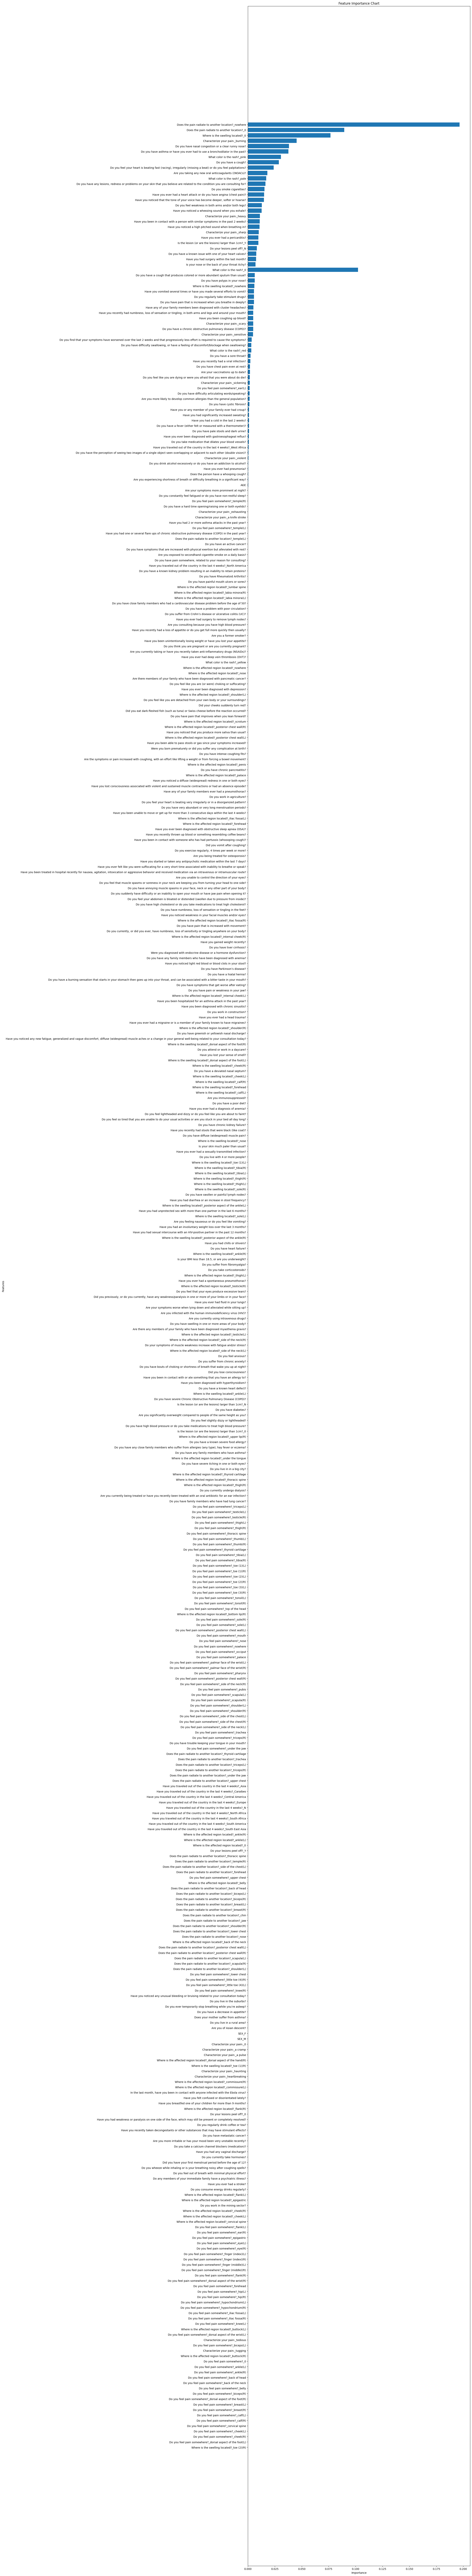

In [ ]:
# Get Feature Importance
best_tree = random_search.best_estimator_
feature_importances = best_tree.feature_importances_

# sort feature  importance in descending order
sorted_index = np.argsort(feature_importances)

# create labels
features = np.array(X.columns)

# plot the features
plt.figure(figsize=(15,len(features)*0.4))
plt.title('Feature Importance Chart')
plt.barh(features[sorted_index], feature_importances[sorted_index])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Get features above given threshold importance
importances = random_search.best_estimator_.feature_importances_
threshold = 0.01
important_indices = np.where(importances > threshold)[0]
important_features = features[important_indices ]
print(important_features)
print(len(important_features))

['Do you smoke cigarettes?' 'Do you have a cough?'
 'Do you have any lesions, redness or problems on your skin that you believe are related to the condition you are consulting for?'
 'Do you have asthma or have you ever had to use a bronchodilator in the past?'
 'Do you have nasal congestion or a clear runny nose?'
 'Have you been in contact with a person with similar symptoms in the past 2 weeks?'
 'Are you taking any new oral anticoagulants ((NOACs)?'
 'Have you ever had a heart attack or do you have angina (chest pain)?'
 'Do you feel your heart is beating fast (racing), irregularly (missing a beat) or do you feel palpitations?'
 'Have you noticed a high pitched sound when breathing in?'
 'Do you feel weakness in both arms and/or both legs?'
 'Have you noticed that the tone of your voice has become deeper, softer or hoarse?'
 'Have you noticed a wheezing sound when you exhale?'
 'Characterize your pain:_burning' 'Characterize your pain:_heavy'
 'Characterize your pain:_sharp'
 'Does